# Analysis of zooplankton data
Here we'll plot and analyze zooplankton data collected with the ZooScan. 
First' we'll load the data and perform a PCA analysis. Second, we'll plot the relative abundance of major groups over time. 

In [5]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import math

In [6]:
# Load data
zooplankton = pd.read_csv('../data/raw/zooscan_data.csv', sep=';', index_col=0)
zooplankton.index = pd.to_datetime(zooplankton.index)

# Only include data from stations 51 and 130
zooplankton['StationPrefix'] = [x.split('_')[0] for x in zooplankton['Station']]
zooplankton = zooplankton[zooplankton['StationPrefix'].isin(['51', '130'])]

# Change NaNs to 0
zooplankton = zooplankton.fillna(0)

# Remove rows with all 0s
zooplankton = zooplankton.loc[(zooplankton!=0).any(axis=1)]

# Load environmental data
env = pd.read_csv('../data/raw/environmental_data.csv', sep=';', index_col=0)
env.index = pd.to_datetime(env.index)

# Only include data from stations 51 and 130
env = env[env['StationPrefix'].isin(['51', '130'])]

## PCA

In [7]:
# Only retain zooplankton columns
zooplankton = zooplankton.drop(['Station', 'StationPrefix', 'Month', 'Year', 'Day', 'Hour', 'Minute'], axis=1)
# Remove noisy functional categories (values < 1) to remove noise below the detection limit
zooplankton[zooplankton < 1] = 0

# log transform the transposed data
zooplankton_log = np.log(zooplankton +1)

# Check if the indices are the same
assert (zooplankton_log.index == env.index).all()

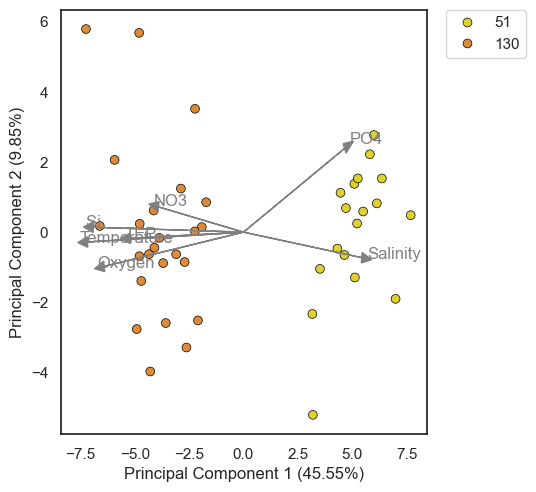

In [8]:
pca_data = zooplankton_log.merge(env, left_index=True, right_index=True)

# Remove rows with all 0s in zooplankton data
mask = (pca_data[zooplankton_log.columns] != 0).any(axis=1)
pca_data = pca_data[mask]

# Perform PCA on gene expression data, ignore columns that are also in the environmental variables
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(pca_data.drop(columns=env.columns))

# Add principal components to the data
pca_data['PC1'] = principalComponents[:, 0]
pca_data['PC2'] = principalComponents[:, 1]

# Create a color dictionary for the months
station_color_dict = {
    '51':            "#dfd032",
    '130':         "#dd8b38"
}

# Set figure size and font scale
cm = 1/2.54
plt.figure(figsize=(12*cm, 14*cm))

# Plot PCA biplot with the color of the month corrresponding to the month of the sample
# and the shape of the point corresponding to the station of the sample
sns.set(style='white', font_scale=1)
sns.scatterplot(data=pca_data,
                x='PC1',
                y='PC2',
                hue='StationPrefix',
                palette=station_color_dict,
                s=40, edgecolor='black', linewidth=0.5)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Plot labels with the variance explained by each principal component
plt.xlabel('Principal Component 1 ({}%)'.format(round(pca.explained_variance_ratio_[0] * 100, 2)))
plt.ylabel('Principal Component 2 ({}%)'.format(round(pca.explained_variance_ratio_[1] * 100, 2)))

# Plot arrows indicating the correlation between the principal components and the environmental variables
## Linear regression to determine the correlation between the principal components and the environmental variables
columns_of_interest = ['NO3', 'PO4', 'Si ', 'Salinity', 'Temperature', 'Oxygen', 'TEP']

# Scale the environmental variables
pca_data[columns_of_interest] = StandardScaler().fit_transform(pca_data[columns_of_interest])

# Calculate the correlation matrix between the principal components and the environmental variables
corr_matrix = np.corrcoef(pca_data[['PC1', 'PC2'] + columns_of_interest].dropna().T)

# Get the correlation between the first two principal components and each environmental parameter
corr_PC1_env = corr_matrix[0, 2:]
corr_PC2_env = corr_matrix[1, 2:]

# Plot the arrows representing the correlations
for i, env_param in enumerate(columns_of_interest):
    plt.arrow(0, 0, corr_PC1_env[i]*max(pca_data['PC1']), corr_PC2_env[i]*max(pca_data['PC2']), head_width=0.3, color='gray')
    # corr_PC1_env[i] specifies the end coordinate of the arrow in the x direction
    # This coordinate is multiplied with max(pca_data['PC1']) to scale the arrow to the length of the principal component for visualization
    plt.text(corr_PC1_env[i]*max(pca_data['PC1'])*1.05, corr_PC2_env[i]*max(pca_data['PC2'])*1.05, env_param, fontsize=12, color='gray')
    # Same as above, but the text is placed 5% further away from the arrow

# Save the figure as svg
plt.savefig(f'../figures/zooplankton/ZooScan_PCA_biplot.svg', format='svg', bbox_inches='tight')
plt.savefig(f'../figures/zooplankton/ZooScan_PCA_biplot.png', format='png', bbox_inches='tight')

plt.show()

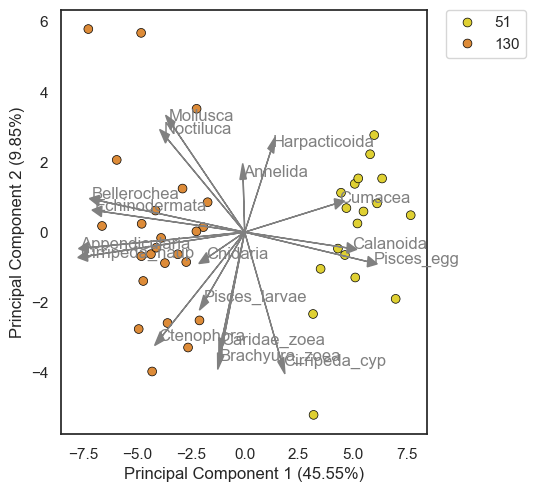

In [9]:
plt.figure(figsize=(12*cm, 14*cm))

# Plot PCA biplot with the color of the month corrresponding to the month of the sample
# and the shape of the point corresponding to the station of the sample
sns.set(style='white', font_scale=1)
sns.scatterplot(data=pca_data,
                x='PC1',
                y='PC2',
                hue='StationPrefix',
                palette=station_color_dict,
                s=40, edgecolor='black', linewidth=0.5)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Plot labels with the variance explained by each principal component
plt.xlabel('Principal Component 1 ({}%)'.format(round(pca.explained_variance_ratio_[0] * 100, 2)))
plt.ylabel('Principal Component 2 ({}%)'.format(round(pca.explained_variance_ratio_[1] * 100, 2)))

# Plot arrows indicating the correlation between the principal components and the environmental variables
## Linear regression to determine the correlation between the principal components and the environmental variables
columns_of_interest = ['Annelida', 'Appendicularia', 'Bellerochea', 'Brachyura_zoea',
       'Calanoida', 'Caridae_zoea', 'Cirripeda_cyp', 'Cirripeda_naup',
       'Cnidaria', 'Ctenophora', 'Cumacea', 'Echinodermata', 'Harpacticoida',
       'Mollusca', 'Noctiluca', 'Pisces_egg', 'Pisces_larvae']

# Scale the environmental variables
pca_data[columns_of_interest] = StandardScaler().fit_transform(pca_data[columns_of_interest])

# Calculate the correlation matrix between the principal components and the environmental variables
corr_matrix = np.corrcoef(pca_data[['PC1', 'PC2'] + columns_of_interest].dropna().T)

# Get the correlation between the first two principal components and each environmental parameter
corr_PC1_env = corr_matrix[0, 2:]
corr_PC2_env = corr_matrix[1, 2:]

# Plot the arrows representing the correlations
for i, env_param in enumerate(columns_of_interest):
    plt.arrow(0, 0, corr_PC1_env[i]*max(pca_data['PC1']), corr_PC2_env[i]*max(pca_data['PC2']), head_width=0.3, color='gray')
    # corr_PC1_env[i] specifies the end coordinate of the arrow in the x direction
    # This coordinate is multiplied with max(pca_data['PC1']) to scale the arrow to the length of the principal component for visualization
    plt.text(corr_PC1_env[i]*max(pca_data['PC1'])*1.05, corr_PC2_env[i]*max(pca_data['PC2'])*1.05, env_param, fontsize=12, color='gray')
    # Same as above, but the text is placed 5% further away from the arrow

# Save the figure as svg
plt.savefig(f'../figures/zooplankton/ZooScan_PCA_biplot_2.svg', format='svg', bbox_inches='tight')
plt.savefig(f'../figures/zooplankton/ZooScan_PCA_biplot_2.png', format='png', bbox_inches='tight')

plt.show()

## Relative abundance of major groups over time

In [10]:
# Transfer zooscan data to long format
zooplankton_long = zooplankton.reset_index().melt(id_vars='StartDate', var_name='ZooScan_group', value_name='count')

# Merge with environmental data
zooplankton_long = zooplankton_long.merge(env[['StationPrefix', 'Station']], left_on='StartDate', right_index=True)

In [11]:
stations = ['51', '130']

for station in stations:
    grouped_df = zooplankton_long[zooplankton_long['StationPrefix'] == station][['StartDate', 'ZooScan_group', 'count']]
    grouped_df['datetime'] = grouped_df['StartDate'].dt.date.astype(str) + ' ' + grouped_df['StartDate'].dt.hour.astype(str) + ':00'
    grouped_df['datetime'] = pd.to_datetime(grouped_df['datetime'], format='%Y-%m-%d %H:%M')

    grouped_df = grouped_df.groupby(['datetime', 'ZooScan_group']).agg({'count':'sum'}).reset_index()
    grouped_df["rel_occurrence"] = grouped_df.groupby(['datetime'])['count'].transform(lambda x: x / x.sum())
   
   # Combine low-abundant groups into a single 'Rare' category
    threshold = 0.05
    grouped_df.loc[grouped_df['rel_occurrence'] <= threshold, 'ZooScan_group'] = 'Rare'

    fig = px.bar(grouped_df, 
                x="datetime", 
                y="rel_occurrence",
                
                color='ZooScan_group',
                color_discrete_map={
                    "Rare": "#545454",
                    "Noctiluca": "#56B4E8",
                    "Calanoida": "#F18E8E",
                    "Echinodermata": "#009A83",
                    "Harpacticoida": "#F0E442",
                    "Mollusca": "#FF6600",
                    "Pisces_egg": "#FFCC99",
                    "Pisces_larvae": "#6600CC",
                }
            )

    fig.update_layout(
        width=800,
        height=400,
        xaxis_title='Date and Time',
        yaxis_title='Relative Zooplankton Abundance',
        xaxis_tickangle=-45,
        legend_title='Taxonomic Group',
        title_text='Station {}'.format(station),
    )

    fig.show()

    # Save figure as svg
    fig.write_image("../figures/zooplankton/zooscan_relative_occurrence_{}.svg".format(station), scale=1)
    fig.write_image("../figures/zooplankton/zooscan_relative_occurrence_{}.png".format(station), scale=1)

/opt/homebrew/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:107: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


/opt/homebrew/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:107: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [12]:
stations = ['51', '130']

for station in stations:
    grouped_df = zooplankton_long[zooplankton_long['StationPrefix'] == station][['StartDate', 'ZooScan_group', 'count']]
    grouped_df['datetime'] = grouped_df['StartDate'].dt.date.astype(str) + ' ' + grouped_df['StartDate'].dt.hour.astype(str) + ':00'
    grouped_df['datetime'] = pd.to_datetime(grouped_df['datetime'], format='%Y-%m-%d %H:%M')

    grouped_df = grouped_df.groupby(['datetime', 'ZooScan_group']).agg({'count':'sum'}).reset_index()
    grouped_df["rel_occurrence"] = grouped_df.groupby(['datetime'])['count'].transform(lambda x: x / x.sum())
   
   # Combine low-abundant groups into a single 'Rare' category
    threshold = 0.05
    grouped_df.loc[grouped_df['rel_occurrence'] <= threshold, 'ZooScan_group'] = 'Rare'

    fig = px.bar(grouped_df, 
                x="datetime", 
                y="count",
                
                color='ZooScan_group',
                color_discrete_map={
                    "Rare": "#545454",
                    "Noctiluca": "#56B4E8",
                    "Calanoida": "#F18E8E",
                    "Echinodermata": "#009A83",
                    "Harpacticoida": "#F0E442",
                    "Mollusca": "#FF6600",
                    "Pisces_egg": "#FFCC99",
                    "Pisces_larvae": "#6600CC",
                }
            )

    fig.update_layout(
        width=800,
        height=400,
        xaxis_title='Date and Time',
        yaxis_title='Absolute Zooplankton Abundance',
        xaxis_tickangle=-45,
        legend_title='Taxonomic Group',
        title_text='Station {}'.format(station),
    )

    fig.show()

    # Save figure as svg
    fig.write_image("../figures/zooplankton/zooscan_absolute_abundance_{}.svg".format(station), scale=1)
    fig.write_image("../figures/zooplankton/zooscan_absolute_abundance_{}.png".format(station), scale=1)

/opt/homebrew/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:107: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



/opt/homebrew/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:107: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [13]:
# Export total Zooplankton counts per sample to csv
zooplankton_counts = zooplankton_long.groupby(['Station']).agg({'count':'sum'}).reset_index()
# Rename columns
zooplankton_counts.columns = ['Station', 'Total_Zooplankton_Count']
zooplankton_counts.to_csv('../data/analysis/zooplankton_counts.csv', index=False)